In [1]:
import os
import logging


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import dill

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal, AutoDelta
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam
from chirho.indexed.handlers import IndexPlatesMessenger
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition


from cities.utils.data_grabber import (DataGrabber, list_available_features, list_tensed_features, list_interventions, list_outcomes)
from cities.utils.cleaning_utils import check_if_tensed, find_repo_root
from cities.modeling.model_interactions import cities_model_interactions as model
from cities.modeling.model_interactions import InteractionsModel
from cities.modeling.modeling_utils import (prep_data_for_interaction_inference,  train_interactions_model)
from cities.utils.cleaning_utils import find_repo_root


In [85]:


def aprep_data_for_interaction_inference(
    outcome_dataset, intervention_dataset, intervention_variable, forward_shift
):
    
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    dg = DataGrabber()

    tensed_covariates_datasets = [
        var
        for var in list_tensed_features()
        if var not in [outcome_dataset, intervention_dataset]
    ]
    fixed_covariates_datasets = [
        var
        for var in list_available_features()
        if var
        not in tensed_covariates_datasets + [outcome_dataset, intervention_dataset]
    ]

    # TODO revise once transformations are available
    dg.get_features_std_long(list_available_features())
    dg.get_features_std_wide(list_available_features())

    year_min = max(
        dg.std_long[intervention_dataset]["Year"].min(),
        dg.std_long[outcome_dataset]["Year"].min(),
    )
    year_max = min(
        dg.std_long[intervention_dataset]["Year"].max(),
        dg.std_long[outcome_dataset]["Year"].max(),
    )
    outcome_df = dg.std_long[outcome_dataset].sort_values(by=["GeoFIPS", "Year"])

    # now we are adding forward shift to the outcome
    # cleaning up and puting intervention/outcome in one df
    # and fixed covariates in another

    outcome_df[f"{outcome_dataset}_shifted_by_{forward_shift}"] = None

    geo_subsets = []
    for geo_fips in outcome_df["GeoFIPS"].unique():
        geo_subset = outcome_df[outcome_df["GeoFIPS"] == geo_fips].copy()
        # Shift the 'Value' column `forward_shift` in a new column
        geo_subset[f"{outcome_dataset}_shifted_by_{forward_shift}"] = geo_subset[
            "Value"
        ].shift(-forward_shift)
        geo_subsets.append(geo_subset)

    outcome_df = pd.concat(geo_subsets).reset_index(drop=True)

    outcome = outcome_df[
        (outcome_df["Year"] >= year_min)
        & (outcome_df["Year"] <= year_max + forward_shift)
    ]

    
    intervention = dg.std_long[intervention_dataset][
        (dg.std_long[intervention_dataset]["Year"] >= year_min)
        & (dg.std_long[intervention_dataset]["Year"] <= year_max)
    ]


    
    f_covariates = {
        dataset: dg.std_wide[dataset] for dataset in fixed_covariates_datasets
    }
    f_covariates_joint = f_covariates[fixed_covariates_datasets[0]]
    for dataset in f_covariates.keys():
        if dataset != fixed_covariates_datasets[0]:
            if "GeoName" in f_covariates[dataset].columns:
                f_covariates[dataset] = f_covariates[dataset].drop(columns=["GeoName"])
            f_covariates_joint = f_covariates_joint.merge(
                f_covariates[dataset], on=["GeoFIPS"]
            )

    i_o_data = pd.merge(outcome, intervention, on=["GeoFIPS", "Year"])

    if "GeoName_x" in i_o_data.columns:
        i_o_data.rename(columns={"GeoName_x": "GeoName"}, inplace=True)
        columns_to_drop = i_o_data.filter(regex=r"^GeoName_[a-zA-Z]$")
        i_o_data.drop(columns=columns_to_drop.columns, inplace=True)

    i_o_data.rename(columns={"Value": outcome_dataset}, inplace=True)

    i_o_data["state"] = [code // 1000 for code in i_o_data["GeoFIPS"]]

    N_s = len(i_o_data["state"].unique())  # number of states
    i_o_data.dropna(inplace=True)

    i_o_data["unit_index"] = pd.factorize(i_o_data["GeoFIPS"].values)[0]
    i_o_data["state_index"] = pd.factorize(i_o_data["state"].values)[0]
    i_o_data["time_index"] = pd.factorize(i_o_data["Year"].values)[0]

    assert i_o_data["GeoFIPS"].isin(f_covariates_joint["GeoFIPS"]).all()

    print(outcome_dataset)
    display(i_o_data.head())
    print("null?", i_o_data.isnull().any())

    y_for_tensor = i_o_data[["GeoFIPS", "Year", f"{outcome_dataset}_shifted_by_{forward_shift}"]].copy()

    display(y_for_tensor.pivot(index='Year', columns='GeoFIPS', values='industry_transportation_warehousing_total_shifted_by_1').head())
#    y_for_tensor = y_for_tensor.pivot(index="Year", columns="GeoFIPS", values=f"{outcome_dataset}_shifted_by_{forward_shift}")
#    display(y_for_tensor.head())

    #print(y_for_tensor.shape)

    #y_reshaped =torch.Tensor(y_for_tensor.values, dtype= torch.float32, device=device)

    # f_covariates_joint.drop(columns=["GeoName"], inplace=True)
    # data = i_o_data.merge(f_covariates_joint, on="GeoFIPS", how="left")

    # # assert not data.isna().any().any()

    # time_index_idx = data.columns.get_loc("time_index")
    # covariates_df = data.iloc[:, time_index_idx + 1 :].copy()
    # covariates_df_sparse = covariates_df.copy()
    # covariates_df_sparse["unit_index"] = data["unit_index"]
    # covariates_df_sparse["state_index"] = data["state_index"]
    # covariates_df_sparse.drop_duplicates(inplace=True)
    # assert set(covariates_df_sparse["unit_index"]) == set(data["unit_index"])

    # # get tensors

    # if torch.cuda.is_available():
    #     device = torch.device("cuda")
    # else:
    #     device = torch.device("cpu")

    # y = data[f"{outcome_dataset}_shifted_by_{forward_shift}"]
    # y = torch.tensor(y, dtype=torch.float32, device=device)

    # unit_index = torch.tensor(data["unit_index"], dtype=torch.int, device=device)
    # unit_index_sparse = torch.tensor(
    #     covariates_df_sparse["unit_index"], dtype=torch.int
    # )

    # state_index = torch.tensor(data["state_index"], dtype=torch.int, device=device)
    # state_index_sparse = torch.tensor(
    #     covariates_df_sparse["state_index"], dtype=torch.int
    # )

    # time_index = torch.tensor(data["time_index"], dtype=torch.int, device=device)
    # intervention = torch.tensor(
    #     data[intervention_variable], dtype=torch.float32, device=device
    # )

    # covariates = torch.tensor(covariates_df.values, dtype=torch.float32, device=device)

    # covariates_df_sparse.drop(columns=["unit_index", "state_index"], inplace=True)
    # covariates_sparse = torch.tensor(
    #     covariates_df_sparse.values, dtype=torch.float32, device=device
    # )

    # N_cov = covariates.shape[1]  # number of covariates
    # N_u = covariates_sparse.shape[0]  # number of units (counties)
    # N_obs = len(y)  # number of observations
    # N_t = len(time_index.unique())  # number of time points
    # N_s = len(state_index.unique())  # number of states

    # assert len(intervention) == len(y)
    # assert len(unit_index) == len(y)
    # assert len(state_index) == len(unit_index)
    # assert len(time_index) == len(unit_index)
    # assert covariates.shape[1] == covariates_sparse.shape[1]
    # # assert len(unit_index_sparse) == N_u

    # return {
    #     "N_t": N_t,
    #     "N_cov": N_cov,
    #     "N_s": N_s,
    #     "N_u": N_u,
    #     "N_obs": N_obs,
    #     "unit_index": unit_index,
    #     "state_index": state_index,
    #     "time_index": time_index,
    #     "unit_index_sparse": unit_index_sparse,
    #     "state_index_sparse": state_index_sparse,
    #     "covariates": covariates,
    #     "covariates_sparse": covariates_sparse,
    #     "intervention": intervention,
    #     "y": y,
    # }

In [86]:
outcome_dataset='industry_transportation_warehousing_total'
intervention_dataset='spending_transportation'
forward_shift = 1

dg = DataGrabber()

dg.get_features_std_long([intervention_dataset, outcome_dataset])

intervention_variable = dg.std_long[intervention_dataset].columns[-1]

loaded_data = {}
loaded_data[forward_shift] =  aprep_data_for_interaction_inference(
        outcome_dataset=outcome_dataset,
intervention_dataset=intervention_dataset,
intervention_variable=intervention_variable,
forward_shift=forward_shift, 
    )



# model_args= (
#         loaded_data[forward_shift]['N_t'],
#         loaded_data[forward_shift]['N_cov'],
#         loaded_data[forward_shift]['N_s'],
#         loaded_data[forward_shift]['N_u'],
#         loaded_data[forward_shift]['N_obs'],
#         loaded_data[forward_shift]['state_index_sparse'],
#         loaded_data[forward_shift]['state_index'],
#         loaded_data[forward_shift]['time_index'],
#         loaded_data[forward_shift]['unit_index'],
#         loaded_data[forward_shift]['unit_index_sparse'],
#     )


industry_transportation_warehousing_total


,GeoFIPS,GeoName,Year,industry_transportation_warehousing_total,industry_transportation_warehousing_total_shifted_by_1,total_obligated_amount,state,unit_index,state_index,time_index
0,1001,"Autauga, AL",2011,-0.021835,-0.020478,-0.022550,1,0,0,0
1,1001,"Autauga, AL",2012,-0.020478,-0.018844,-0.022784,1,0,0,1
2,1001,"Autauga, AL",2013,-0.018844,-0.022535,-0.022741,1,0,0,2
3,1001,"Autauga, AL",2014,-0.022535,-0.019502,-0.022771,1,0,0,3
4,1001,"Autauga, AL",2015,-0.019502,-0.018059,-0.022715,1,0,0,4


null? GeoFIPS                                                   False
GeoName                                                   False
Year                                                      False
industry_transportation_warehousing_total                 False
industry_transportation_warehousing_total_shifted_by_1    False
total_obligated_amount                                    False
state                                                     False
unit_index                                                False
state_index                                               False
time_index                                                False
dtype: bool


GeoFIPS,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
Year,,,,,,,,,,,,,,,,,,,,,
2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011,-0.020478,0.023637,-0.034474,-0.031803,-0.015874,NaN,-0.036593,NaN,-0.036360,-0.032163,...,-0.041213,-0.032905,-0.037187,-0.028601,-0.036381,-0.013370,-0.034474,-0.031845,NaN,-0.040260
2012,-0.018844,0.023595,-0.034453,NaN,NaN,NaN,-0.038310,NaN,-0.037060,-0.034219,...,-0.041616,-0.033478,NaN,-0.029767,-0.036403,-0.013710,-0.030594,-0.033668,-0.039264,-0.040662
2013,-0.022535,0.017209,-0.035491,-0.036233,-0.015895,NaN,-0.038098,NaN,-0.036360,-0.035449,...,NaN,-0.038056,NaN,-0.031251,NaN,-0.016171,-0.030912,-0.032227,-0.038734,-0.039603
2014,-0.019502,0.019861,-0.035449,-0.035364,-0.019014,NaN,-0.038501,NaN,-0.037695,NaN,...,NaN,-0.038035,-0.037102,-0.030255,-0.038670,-0.017104,-0.032206,-0.032439,-0.040789,-0.038988


In [122]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

dg = DataGrabber()

forward_shift = 2

tensed_covariates_datasets = [
    var
    for var in list_tensed_features()
    if var not in [outcome_dataset, intervention_dataset]
]
fixed_covariates_datasets = [
    var
    for var in list_available_features()
    if var
    not in tensed_covariates_datasets + [outcome_dataset, intervention_dataset]
]

dg.get_features_std_long(list_available_features())
dg.get_features_std_wide(list_available_features())


intervention = dg.std_wide[intervention_dataset]
outcome = dg.std_wide[outcome_dataset]

year_min =  max(
intervention.columns[2:].astype(int).min(),
outcome.columns[2:].astype(int).min(),
)

year_max = min(
    intervention.columns[2:].astype(int).max(),
    outcome.columns[2:].astype(int).max(),
)

assert all(intervention['GeoFIPS'] == outcome['GeoFIPS'])

outcome_shifted = outcome.copy()
for year in range(year_min, year_max - forward_shift+ 1):
    outcome_shifted[f'{year}'] = outcome_shifted[f'{year + forward_shift}']

years_to_drop = [f"{year}" for year in range(year_max - forward_shift + 1, year_max + 1) ] 

outcome_shifted.drop(columns= years_to_drop, inplace=True)
intervention.drop(columns= years_to_drop, inplace=True)

assert outcome_shifted['GeoFIPS'].equals(intervention['GeoFIPS'])
assert outcome_shifted['GeoFIPS'].nunique() == len(outcome_shifted['GeoFIPS'])

y = torch.tensor(outcome_shifted.iloc[:, 2:].values, dtype=torch.float32, device=device)


print(y.viewview(10, 1, 1, 3074).shape)

display(outcome.head())
display(intervention.head())
display(outcome_shifted.head())

torch.Size([3074, 10])


,GeoFIPS,GeoName,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,1001,"Autauga, AL",-0.026565,-0.021835,-0.020478,-0.018844,-0.022535,-0.019502,-0.018059,-0.013794,-0.015343,-0.014134,-0.018568,-0.023256
1,1003,"Baldwin, AL",0.024846,0.025610,0.023637,0.023595,0.017209,0.019861,0.023849,0.027900,0.032099,0.032650,0.038945,0.036953
2,1005,"Barbour, AL",-0.031188,-0.033308,-0.034474,-0.034453,-0.035491,-0.035449,-0.034241,-0.034749,-0.033308,-0.034304,-0.035173,-0.034198
3,1007,"Bibb, AL",-0.024614,-0.028855,-0.031803,-0.034198,-0.036233,-0.035364,-0.033478,-0.034156,-0.035979,-0.034622,-0.033456,-0.034453
4,1009,"Blount, AL",-0.015471,-0.015831,-0.015874,-0.013031,-0.015895,-0.019014,-0.016722,-0.018802,-0.022302,-0.018844,-0.013901,-0.012182


,GeoFIPS,GeoName,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,1001,"Autauga, AL",-0.01185,-0.015662,-0.017365,-0.017679,-0.017568,-0.017024,-0.015075,-0.016924,-0.016380,-0.017228
1,1003,"Baldwin, AL",-0.01185,-0.015415,-0.016643,-0.015735,-0.016022,-0.015177,-0.013031,-0.016428,-0.015011,-0.016931
2,1005,"Barbour, AL",-0.01185,-0.016004,-0.017285,-0.017582,-0.017264,-0.017004,-0.015082,-0.016778,-0.016379,-0.016889
3,1007,"Bibb, AL",-0.01185,-0.016208,-0.017417,-0.017825,-0.017600,-0.017200,-0.015107,-0.017045,-0.016352,-0.017110
4,1009,"Blount, AL",-0.01185,-0.016232,-0.017417,-0.017660,-0.017457,-0.017112,-0.015046,-0.017099,-0.016324,-0.017163


,GeoFIPS,GeoName,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,1001,"Autauga, AL",-0.020478,-0.018844,-0.022535,-0.019502,-0.018059,-0.013794,-0.015343,-0.014134,-0.018568,-0.023256
1,1003,"Baldwin, AL",0.023637,0.023595,0.017209,0.019861,0.023849,0.027900,0.032099,0.032650,0.038945,0.036953
2,1005,"Barbour, AL",-0.034474,-0.034453,-0.035491,-0.035449,-0.034241,-0.034749,-0.033308,-0.034304,-0.035173,-0.034198
3,1007,"Bibb, AL",-0.031803,-0.034198,-0.036233,-0.035364,-0.033478,-0.034156,-0.035979,-0.034622,-0.033456,-0.034453
4,1009,"Blount, AL",-0.015874,-0.013031,-0.015895,-0.019014,-0.016722,-0.018802,-0.022302,-0.018844,-0.013901,-0.012182


XT_weighted torch.Size([1, 1, 3065])
bias_Y torch.Size([])
bias_T torch.Size([])
weight_TY torch.Size([])
sigma_T torch.Size([])
sigma_Y torch.Size([])
bias_X torch.Size([30, 1, 1])
sigma_X torch.Size([30, 1, 1])
weight_XT torch.Size([30, 1, 1])
weight_XY torch.Size([30, 1, 1])
bias_stateT torch.Size([51, 1])
bias_stateY torch.Size([51, 1])
bias_stateX torch.Size([30, 51, 1])
bias_timeT torch.Size([11, 1, 1, 1])
bias_timeY torch.Size([11, 1, 1, 1])
mean_X torch.Size([30, 1, 3065])
X torch.Size([30, 1, 3065])
bias_stateT_tiled torch.Size([1, 3065])
mean_T torch.Size([11, 1, 1, 3065])
T torch.Size([11, 1, 1, 3065])
bias_stateY_tiled torch.Size([1, 3065])
mean_Y torch.Size([11, 1, 1, 3065])
Y torch.Size([11, 1, 1, 3065])
XT_weighted (1, 1, 3065)


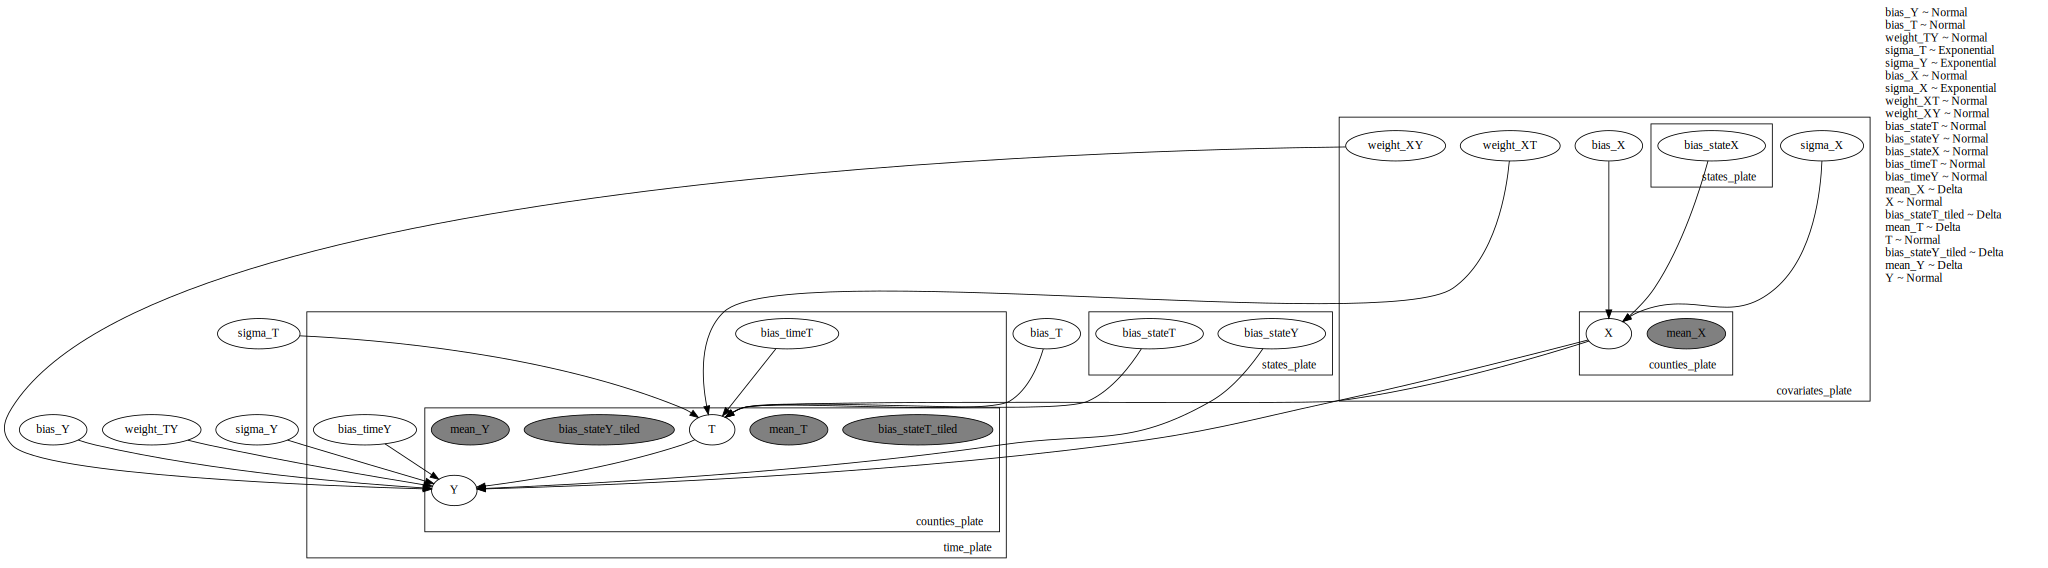

In [130]:
def model_testing(
    N_t,
    N_cov,
    N_s,
    N_u,
    N_obs,
    state_index_sparse,
    state_index,
    time_index,
    unit_index,
    unit_index_sparse,
    leeway=0.2,
):
    bias_Y = pyro.sample("bias_Y", dist.Normal(0, leeway))
    bias_T = pyro.sample("bias_T", dist.Normal(0, leeway))

    weight_TY = pyro.sample("weight_TY", dist.Normal(0, leeway))

    sigma_T = pyro.sample("sigma_T", dist.Exponential(1))
    sigma_Y = pyro.sample("sigma_Y", dist.Exponential(1))
 
    counties_plate = pyro.plate("counties_plate", N_u, dim=-1)
    states_plate = pyro.plate("states_plate", N_s, dim=-2)
    covariates_plate = pyro.plate("covariates_plate", N_cov, dim=-3)
    time_plate = pyro.plate("time_plate", N_t, dim=-4)

    with covariates_plate:
        bias_X = pyro.sample("bias_X", dist.Normal(0, leeway))
        sigma_X = pyro.sample("sigma_X", dist.Exponential(1))
        weight_XT = pyro.sample("weight_XT", dist.Normal(0, leeway))
        weight_XY = pyro.sample("weight_XY", dist.Normal(0, leeway))

    with states_plate:
        bias_stateT = pyro.sample("bias_stateT", dist.Normal(0, leeway))
        bias_stateY = pyro.sample("bias_stateY", dist.Normal(0, leeway))

        with covariates_plate:
            bias_stateX = pyro.sample("bias_stateX", dist.Normal(0, leeway))

    with time_plate:
        bias_timeT = pyro.sample("bias_timeT", dist.Normal(0, leeway))
        bias_timeY = pyro.sample("bias_timeY", dist.Normal(0, leeway))

    with counties_plate:
        with covariates_plate:
        
            mean_X = pyro.deterministic("mean_X", torch.einsum("...xdd,...xcd->...xdc", bias_X, bias_stateX[...,state_index_sparse,:])) #.unsqueeze(-1))
            #print("xmeans inside", mean_X[...,unit_index_sparse].shape)
        #print("mean_X inside", mean_X.shape) 
            
            
            X = pyro.sample("X", dist.Normal(mean_X[...,unit_index_sparse], sigma_X)) # cudd
        
            XT_weighted =  torch.einsum("...xdc, ...xdd -> ...dc", X, weight_XT).unsqueeze(-2)
            XY_weighted =  torch.einsum("...xdc, ...xdd -> ...dc", X, weight_XY).unsqueeze(-2)
            print("XT_weighted", XT_weighted.shape)
        #      # dudd

        # print("bsT", bias_stateT.shape)
        # print("bsTindexed", bias_stateT[...,state_index_sparse,:].shape ) #[...,state_index_sparse,:].shape)
        # print("sanity", (bias_T + bias_timeT + bias_stateT[...,state_index_sparse,:]).shape)


        with time_plate:
            
            bias_stateT_tiled = pyro.deterministic("bias_stateT_tiled", torch.einsum("...cd -> ...dc", bias_stateT[...,state_index_sparse,:]))
            
            mean_T = pyro.deterministic("mean_T",  bias_T + bias_timeT + bias_stateT_tiled +  XT_weighted)

            T = pyro.sample("T", dist.Normal(mean_T, sigma_T))
            
            bias_stateY_tiled = pyro.deterministic("bias_stateY_tiled", torch.einsum("...cd -> ...dc", 
                                                                        bias_stateY[...,state_index_sparse,:]))
            # same dimension switchiing as for T_bias_with_state

            # #print("Y_bias_with_state", Y_bias_with_state.shape) 
            # Y_bias_with_time = pyro.deterministic("Y_bias_with_time", torch.einsum("...c, ...tddd -> tdc",
            #                                                 Y_bias_with_state, bias_timeY).unsqueeze(-2))
            
            # #print("wty", (weight_TY * T).shape)
            # Y_bias_with_tau = pyro.deterministic("Y_bias_with_tau",
            #                                       torch.einsum("...tcsu, ...tcsu -> tcsu", Y_bias_with_time, weight_TY * T))

            #print("linewise", XY_weighted[...,unit_index_sparse].shape)

            mean_Y = pyro.deterministic("mean_Y", 
                                        bias_Y + bias_timeY + bias_stateY_tiled + XY_weighted + weight_TY * T)
            
            # Y_with_state_bias_and_tau =  torch.einsum("...tddd, ...cd-> ...c", (bias_Y + bias_timeY), bias_stateY[...,state_index_sparse,:]) + weight_TY * T
            # #print("Y with state bias_and_tau", Y_with_state_bias_and_tau.shape)
            # mean_Y = pyro.deterministic("mean_Y", torch.einsum("...tddu, ...u -> tdu",
            #                             Y_with_state_bias_and_tau,
            #                           XY_weighted).unsqueeze(-2)
            #                           )
            
            # # #print("mean_Y", mean_Y.shape)
            Y = pyro.sample("Y", dist.Normal(mean_Y, sigma_Y))

    #             print(mean_T.shape)
    #             print(T.shape)
    # # with observations_plate:
    #     mean_T = 
    # (
    #         bias_T
    #         + weight_UtT[time_index]
    #         + weight_UsT[state_index]
    #         + XT_weighted[unit_index]
    #     )

    #     T = pyro.sample("T", dist.Normal(mean_T, sigma_T))

    #     mean_Y = (
    #         bias_Y
    #         + weight_UtY[time_index]
    #         + weight_UsY[state_index]
    #         + weight_TY * T
    #         + XY_weighted[unit_index]
    #     )

    #     Y = pyro.sample("Y", dist.Normal(mean_Y, sigma_Y))

    # return Y 

with pyro.poutine.trace() as tr:
    model_testing(*model_args)
  
for key in tr.trace.nodes.keys():
    if not key.endswith("plate"):
        print(key, tr.trace.nodes[key]["value"].shape)


pyro.render_model( 
            model_testing, model_args=model_args, render_distributions=True
        )

In [72]:
X = loaded_data[forward_shift]['covariates_sparse']
X_reshaped = X.unsqueeze(1).permute(2, 1, 0)
print(X_reshaped.shape)

#Y = loaded_data[forward_shift]['y']
#print(Y.shape)

torch.Size([30, 1, 3065])


In [73]:
model =  pyro.condition(
            model_testing,
            data={#"T": loaded_data[forward_shift]['intervention'], "Y": loaded_data[forward_shift]['y'], 
                  "X": X_reshaped},
        )



[iteration 0001] loss: 204670.8729
[iteration 0002] loss: 200164.9301
[iteration 0003] loss: 202658.0837
[iteration 0004] loss: 202894.5547
[iteration 0005] loss: 192273.9045
[iteration 0006] loss: 200719.5654
[iteration 0007] loss: 187421.2604
[iteration 0008] loss: 201558.3236
[iteration 0009] loss: 185832.5687
[iteration 0010] loss: 185014.1553
[iteration 0011] loss: 176764.0564
[iteration 0012] loss: 187968.0399
[iteration 0013] loss: 172318.1084
[iteration 0014] loss: 175633.7426
[iteration 0015] loss: 184511.9464
[iteration 0016] loss: 174274.9571
[iteration 0017] loss: 173612.8527
[iteration 0018] loss: 179142.7055
[iteration 0019] loss: 175974.1691
[iteration 0020] loss: 166426.9272
[iteration 0021] loss: 162552.1621
[iteration 0022] loss: 154109.8764
[iteration 0023] loss: 160953.6883
[iteration 0024] loss: 152062.4382
[iteration 0025] loss: 155225.0197
[iteration 0026] loss: 156845.8751
[iteration 0027] loss: 147799.6073
[iteration 0028] loss: 149977.2183
[iteration 0029] los

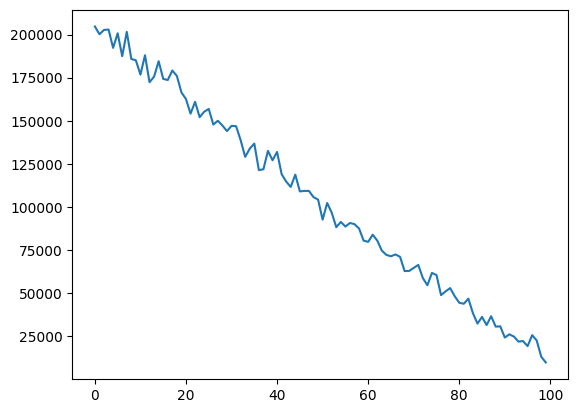

In [74]:
pyro.clear_param_store()
num_iterations = 100
plot_loss = True
print_interval = True
lr = 0.01


guide = AutoNormal(model)

svi = SVI(model=model, guide=guide, optim=Adam({"lr": lr}), loss=Trace_ELBO())

losses = []
for step in range(num_iterations):
    loss = svi.step(*model_args)
    losses.append(loss)
    if step % print_interval == 0:
        print("[iteration %04d] loss: %.4f" % (step + 1, loss))


plt.plot(range(num_iterations), losses, label="Loss")
plt.show()
